In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score
from scipy.stats import boxcox_normmax
from scipy.special import boxcox1p
import seaborn as sns
import missingno as msno

LABEL_SIZE = 18
TITLE_SIZE = 20

In [2]:
train_b = pd.read_csv("raw/data_b_train.csv")
train_m = pd.read_csv("raw/data_m_train.csv")
valid_b = pd.read_csv("raw/data_b_test.csv")
valid_m = pd.read_csv("raw/data_m_test.csv")
train_y = pd.read_csv('raw/y_train.csv')

In [3]:
train_m.replace(-99, np.nan, inplace=True)
train_b.replace(-99, np.nan,inplace=True)
valid_m.replace(-99, np.nan, inplace=True)
valid_b.replace(-99, np.nan,inplace=True)

In [4]:
# # 查看特征缺失率
# def sns_miss_rate(data, name,pic_name):
#     data = (data.isnull().sum() / len(data)) * 100
#     data = data.sort_values(ascending=False)
#     missing_data = pd.DataFrame({'Missing Ratio': data})
    
#     f, ax = plt.subplots(figsize=(15, 5))
#     sns.barplot(x=data, y=data.index,palette = sns.color_palette('deep'))
    
#     plt.xticks(rotation='0',fontsize=LABEL_SIZE)
#     plt.yticks(rotation='0',fontsize=LABEL_SIZE)
#     plt.xlabel('Percent of missing values', fontsize=LABEL_SIZE)
#     plt.ylabel('Features', fontsize=LABEL_SIZE)
#     plt.title('Percent missing '+ name + ' data by feature', fontsize=TITLE_SIZE)
    
#     counts = data.to_list()
    
#     for i in range(len(counts)):
#         plt.text(i,counts[i]+1,s=str(counts[i]),horizontalalignment= 'center', verticalalignment='bottom', fontsize=LABEL_SIZE)
    
#     plt.savefig(pic_name, dpi=720, bbox_inches='tight')

In [5]:
# sns_miss_rate(train_all.drop(['id'],axis=1)[miss_cols], 'train','训练集缺失率.png')

In [6]:
# 查看特征缺失率
def sns_miss_rate(train, valid):
    train = (train.isnull().sum() / len(train)) * 100
    train = train.sort_values(ascending=False)
#     train.columns = ['miss']
    
    valid = (valid.isnull().sum() / len(valid)) * 100
    valid = valid.sort_values(ascending=False)
#     valid.columns = ['miss']
    return train,valid

In [7]:
miss_cols = ['x_num_19','x_num_38','x_num_27','x_num_10', 'x_num_2', 'x_num_1', 'x_num_3']
train_all = pd.merge(train_b,train_m,on='id')
valid_all = pd.merge(valid_b,valid_m,on='id')
train_miss, valid_miss = sns_miss_rate(train_all.drop(['id'],axis=1)[miss_cols],valid_all.drop(['id'],axis=1)[miss_cols] )

In [8]:
train_miss

x_num_38    100.000000
x_num_19    100.000000
x_num_10     62.331600
x_num_27     62.331600
x_num_2       5.015598
x_num_3       1.779896
x_num_1       1.779896
dtype: float64

In [9]:
valid_miss

x_num_38    100.000000
x_num_19    100.000000
x_num_10     63.331340
x_num_27     63.331340
x_num_2       4.866122
x_num_3       1.630456
x_num_1       1.630456
dtype: float64

In [15]:
# 模型查看重要性
def lgb_importance(data, label):
    train_data = lgb.Dataset(data, label=label)
    params = {'boosting':'gbdt',
          'objective':'binary',
          'max_depth':6,
          'learning_rate':0.01,
          'num_leaves':50,
          'metric': ['binary_logloss', 'auc'],
          'verbose': -1
         }
    model = lgb.train(params, train_data,500)
    importance = pd.DataFrame(list(zip(model.feature_name(),model.feature_importance(importance_type='split'))))
    importance.columns=['feature','split']
    importance = importance[importance['feature'].isin(miss_cols)]
    
    importance= importance.sort_values(by='split', ascending=False)
    f, ax = plt.subplots(figsize=(15, 5))
    
    sns.barplot(x=importance['split'], y=importance['feature'], palette = sns.color_palette('deep'))
    plt.xticks(rotation='0',fontsize=LABEL_SIZE)
    plt.yticks(rotation='0',fontsize=LABEL_SIZE)
    plt.xlabel('Feature importance', fontsize=LABEL_SIZE)
    plt.ylabel('Features', fontsize=LABEL_SIZE)
    plt.title('Feature importance', fontsize=TITLE_SIZE)
    plt.xlim(0,2600)
    counts = importance['split'].to_list()
    
    for i in range(len(counts)):
        plt.text(counts[i]+1,i,s=str(counts[i]),horizontalalignment= 'left', verticalalignment='center', fontsize=LABEL_SIZE)
    plt.savefig('模型特征重要性.png', dpi=720, bbox_inches='tight')

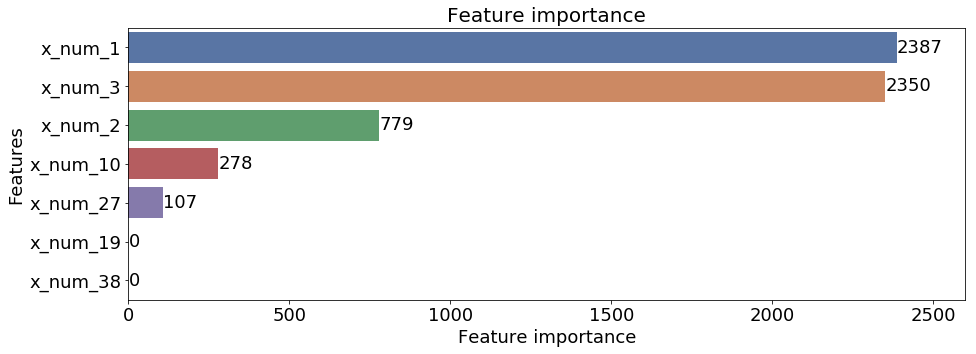

In [16]:
train_all_target = pd.merge(train_all, train_y, on='id')
lgb_importance(train_all_target.drop(['id', 'target'],axis=1), train_all_target['target'])

In [17]:
# # 查看中位数填充，均值填充
# def feature_density(data, col_name):
#     f, ax = plt.subplots(figsize=(15, 8))
#     data_null = data.replace(-99, np.nan)
#     data_null.plot(kind='kde',xlim=(-0.1,1.1))
    
    
#     data_null.fillna(data_null.mean()).plot(kind='kde', xlim=(-0.1,1.1))
#     data_null.fillna(data_null.median()).plot(kind='kde',xlim=(-0.1,1.1))
#     plt.xlabel(col_name, fontsize=15)# plots an axis lable
#     plt.ylabel('Density', fontsize=15) 
#     plt.title(col_name + ' Density', fontsize=15)
#     plt.legend(('origin', 'mean' ,'median'),loc='best')

In [18]:
# 查看中位数填充，均值填充
def feature_density(data, col_name, pic_name):
    
    f, ax = plt.subplots(figsize=(15, 8))
    plate = sns.color_palette('deep')

    data_null = data.replace(-99, np.nan)
    
    sns.kdeplot(data_null.dropna(),color=plate[0])
    sns.kdeplot(data_null.fillna(data_null.mean()), color=plate[1])
    sns.kdeplot(data_null.fillna(data_null.median()),color=plate[2])
    
    plt.xticks(rotation='0',fontsize=LABEL_SIZE)
    plt.yticks(rotation='0',fontsize=LABEL_SIZE)
    plt.xlabel(col_name, fontsize=LABEL_SIZE)
    plt.xlim(-0.1,1.1)
    plt.ylabel('Density', fontsize=LABEL_SIZE)
    plt.title(col_name + ' Density', fontsize=TITLE_SIZE)
    plt.legend(('origin', 'mean' ,'median'),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0, fontsize=LABEL_SIZE)
    plt.savefig(pic_name, dpi=720, bbox_inches='tight')

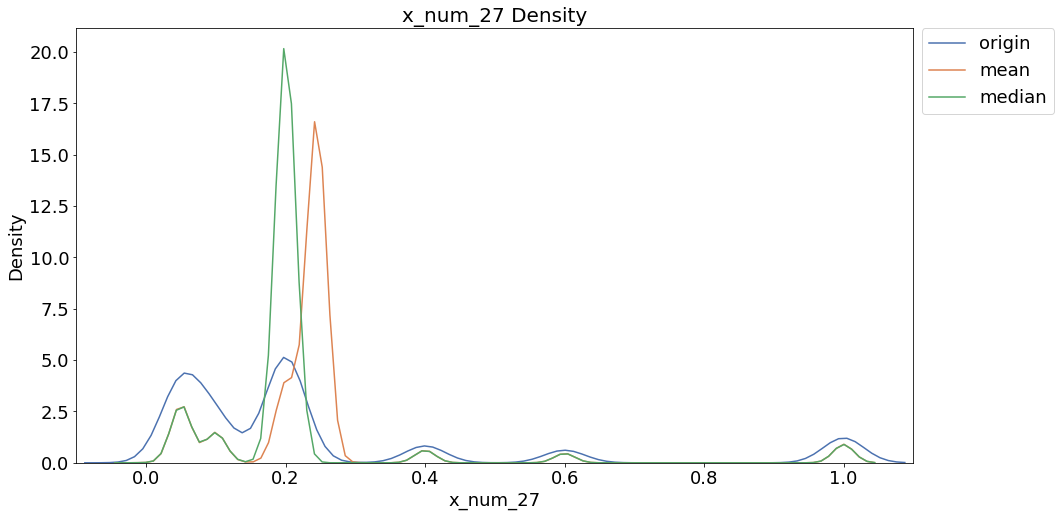

In [19]:
train_b = pd.read_csv("raw/data_b_train.csv")
train_m = pd.read_csv("raw/data_m_train.csv")
valid_b = pd.read_csv("raw/data_b_test.csv")
valid_m = pd.read_csv("raw/data_m_test.csv")
train_y = pd.read_csv('raw/y_train.csv')


feature_density(train_m['x_num_27'], 'x_num_27','train_num_27填充.png')

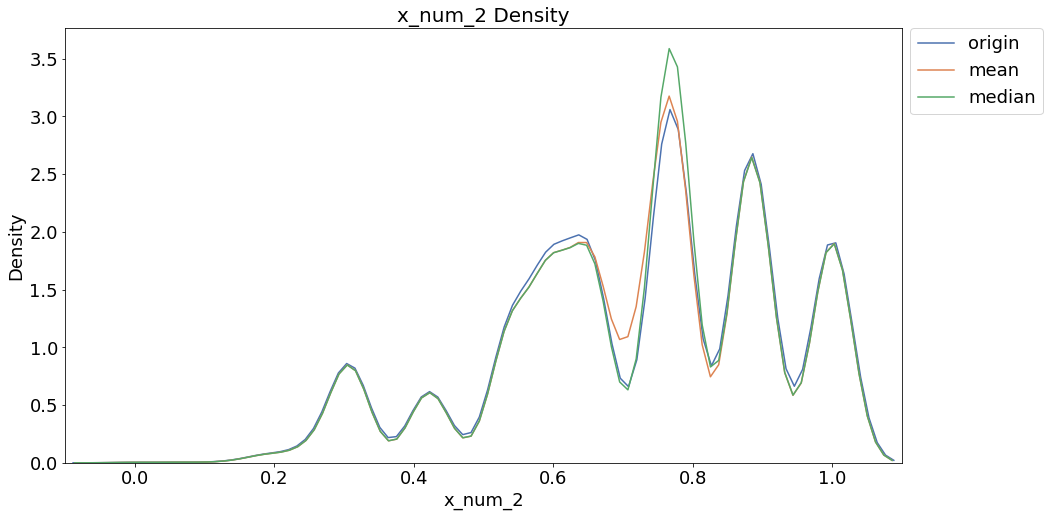

In [20]:

feature_density(train_b['x_num_2'], 'x_num_2', 'train_num_2填充.png')

In [21]:
# # 查看0，1数量
# def bin_num(train, col, label):
# #     f, ax = plt.subplots(figsize=(15, 8))
# #     train[col] = train[col].astype('float16')
# #     train[col].replace(-99.0, -1.0, inplace=True)
    
#     f, ax = plt.subplots(figsize=(15,8))
# #     plate = sns.color_palette('deep')
    
    
#     palette = sns.color_palette('deep')
# #     pd.crosstab(train[col], label).plot(kind='bar')
#     train['a']=train[col].round(decimals=3)
# #     train.drop((train['a']==0.0)||(train['a']==0.017)||(train['a']==0.0)))
#     g = sns.countplot(x='a',hue=label,data=train,palette = sns.color_palette('deep'))
    
# #     
#     plt.xticks(label=[-99.0,0,0.017,0.05,0.1,0.15,0.2,0.3,0.4,0.6,1.0],rotation='0',fontsize=LABEL_SIZE)
#     plt.yticks(rotation='0',fontsize=LABEL_SIZE)
#     plt.xlabel(col, fontsize=LABEL_SIZE)
# #     plt.xlim(-0.2,1.2)
#     plt.ylabel('Count', fontsize=LABEL_SIZE)
#     plt.title(col + ' category', fontsize=TITLE_SIZE)
    
#     plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0, fontsize=LABEL_SIZE)
# #     plt.savefig('train_num_10的target分布.png', dpi=720, bbox_inches='tight')
    

In [22]:
# 查看0，1数量
def bin_num(train, col, label):

    f, ax = plt.subplots(figsize=(15,8))
    plate = sns.color_palette('deep')

    plot_df = pd.DataFrame()
    plot_df['x_num_10'] = [-99.0,0,0.017,0.05,0.1,0.15,0.2,0.3,0.4,0.6,1.0]
    plot_df['total'] = [107896, 51, 2, 15152, 9579, 118, 25717, 35, 4391, 3255, 6904]
    plot_df['count_one'] = [9428, 4, 0, 1921, 1329, 27, 3461, 13, 461, 259, 363]
    
    
    sns.barplot(x = 'x_num_10', y = 'total', data = plot_df, color = plate[0], label='0')
    sns.barplot(x = 'x_num_10', y = 'count_one', data = plot_df, color = plate[1], label='1')
    
    plt.xticks(rotation='0',fontsize=LABEL_SIZE)
    plt.yticks(rotation='0',fontsize=LABEL_SIZE)
    plt.xlabel(col, fontsize=LABEL_SIZE)
#     plt.xlim(-0.2,1.2)
    plt.ylabel('Count', fontsize=LABEL_SIZE)
    plt.title(col + ' category', fontsize=TITLE_SIZE)
    plt.ylim(0,120000)
    
    counts = [107896, 51, 2, 15152, 9579, 118, 25717, 35, 4391, 3255, 6904]
    
    for i in range(len(counts)):
        plt.text(i,counts[i]+1,s=str(counts[i]),horizontalalignment= 'center', verticalalignment='bottom', fontsize=LABEL_SIZE)
        
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0, fontsize=LABEL_SIZE)
    plt.savefig('train_num_10的target分布.png', dpi=720, bbox_inches='tight')
    

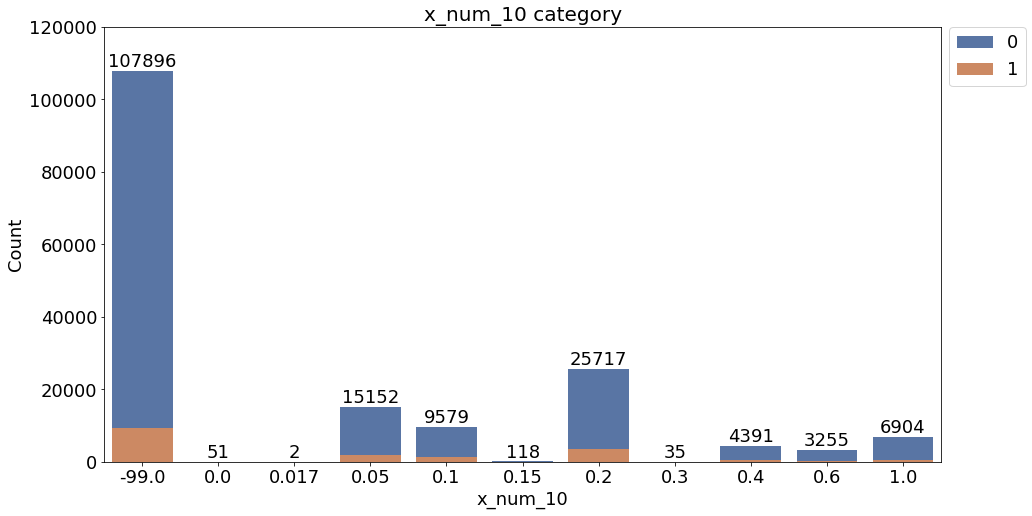

In [23]:
train_b = pd.read_csv("raw/data_b_train.csv")
train_m = pd.read_csv("raw/data_m_train.csv")
valid_b = pd.read_csv("raw/data_b_test.csv")
valid_m = pd.read_csv("raw/data_m_test.csv")
train_y = pd.read_csv('raw/y_train.csv')

bin_num(pd.merge(train_m, train_y, on='id'), 'x_num_10', 'target')

In [24]:
# 1的数量
test = pd.merge(train_m, train_y, on='id')
test_df = pd.crosstab(test['x_num_10'],test['target'])
test_df.columns = [ '0', '1']
test_df['1'].to_list()

[9428, 4, 0, 1921, 1329, 27, 3461, 13, 461, 259, 363]

In [25]:
# 1总的数量
test = pd.merge(train_m, train_y, on='id')
test_df = pd.crosstab(test['x_num_10'],'target')
test_df['target'].to_list()

[107896, 51, 2, 15152, 9579, 118, 25717, 35, 4391, 3255, 6904]

In [26]:
train_all_target['x_num_10']

0         1.0
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
173095    NaN
173096    NaN
173097    NaN
173098    0.1
173099    NaN
Name: x_num_10, Length: 173100, dtype: float64

In [27]:
# train_all_target['x_num_10'].descriebe()

In [28]:
train_m['x_num_10'].value_counts()

-99.000000    107896
 0.200000      25717
 0.050000      15152
 0.100000       9579
 1.000000       6904
 0.400000       4391
 0.600000       3255
 0.150000        118
 0.000000         51
 0.300000         35
 0.016667          2
Name: x_num_10, dtype: int64

In [29]:
# 查看m表中为0的数目
count_zero = pd.DataFrame()

m_last = train_m.sort_values('timestamp', ascending=False).groupby('id',as_index=False).first()
m_last.drop(['id','timestamp'], inplace=True, axis=1)
m_first = train_m.sort_values('timestamp', ascending=False).groupby('id',as_index=False).last()
m_first.drop(['id','timestamp'], inplace=True, axis=1)

count_zero['last'] = m_last.apply(lambda x : x.value_counts().get(0,0),axis=0)

count_zero['first'] = m_first.apply(lambda x : x.value_counts().get(0,0),axis=0)

In [30]:
count_zero['last'].sum()

586439

In [31]:
count_zero['first'].sum()

552044

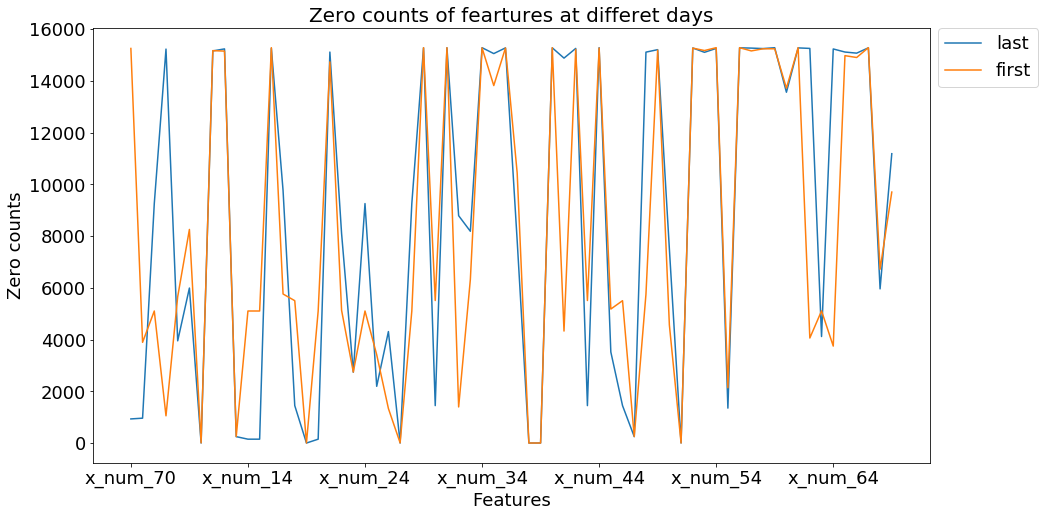

In [32]:

palette = sns.color_palette('deep')

count_zero.plot(kind='line',figsize=(15, 8))
plt.xticks(rotation='0',fontsize=LABEL_SIZE)
plt.yticks(rotation='0',fontsize=LABEL_SIZE)
plt.xlabel('Features', fontsize=LABEL_SIZE)
plt.ylabel('Zero counts', fontsize=LABEL_SIZE)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0, fontsize=LABEL_SIZE)
plt.title('Zero counts of feartures at differet days', fontsize=TITLE_SIZE)
plt.savefig('第一天和最后一天0的总数.png', dpi=720, bbox_inches='tight')

In [33]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score
from scipy.stats import boxcox_normmax
from scipy.special import boxcox1p
import catboost as cb
import seaborn as sns

pd.set_option('display.max_rows', 300)

In [34]:
train_b = pd.read_csv("raw/data_b_train.csv")
train_m = pd.read_csv("raw/data_m_train.csv")
valid_b = pd.read_csv("raw/data_b_test.csv")
valid_m = pd.read_csv("raw/data_m_test.csv")
train_y = pd.read_csv('raw/y_train.csv')


b_col = ['id', 'x_num_0', 'x_num_1', 'x_num_2', 'x_num_3', 'x_cat_0',
         'x_cat_3', 'x_cat_4', 'x_cat_9', 'x_cat_10', 'x_cat_11']


train_b = train_b[b_col]
valid_b = valid_b[b_col]


m_col = ['id','timestamp','x_num_70', 'x_num_5', 'x_num_6', 'x_num_7', 'x_num_10',
         'x_num_13', 'x_num_14', 'x_num_15', 'x_num_17', 'x_num_18', 'x_num_20',
         'x_num_22', 'x_num_23', 'x_num_24', 'x_num_25', 'x_num_26', 'x_num_27',
         'x_num_28', 'x_num_30','x_num_32', 'x_num_33',
         'x_num_39', 'x_num_41', 'x_num_43', 'x_num_45', 'x_num_46',
         'x_num_47', 'x_num_49', 'x_num_50', 'x_num_51', 'x_num_55', 
         'x_num_63', 'x_num_68', 'x_num_69']


train_m = train_m[m_col]
valid_m = valid_m[m_col]

In [35]:
more_cols = ['x_num_70', 'x_num_5', 'x_num_6', 'x_num_7', 'x_num_10',
         'x_num_13', 'x_num_14', 'x_num_15', 'x_num_17', 'x_num_18', 'x_num_20',
         'x_num_22', 'x_num_23', 'x_num_24', 'x_num_25', 'x_num_26', 'x_num_27',
         'x_num_28', 'x_num_30','x_num_32', 'x_num_33',
         'x_num_39', 'x_num_41', 'x_num_43', 'x_num_45', 'x_num_46',
         'x_num_47', 'x_num_49', 'x_num_50', 'x_num_51', 'x_num_55', 
         'x_num_63', 'x_num_68', 'x_num_69']

In [36]:
def change_name(df,suffix):
    names = df.columns.tolist()
    if 'id' in names:
        names.remove('id')
    
    names = [col + suffix for col in names]
    names = ['id'] + names
    df.columns = names
    return df

In [37]:
def pipeline(train,valid,more_cols):
    #最后一天
    train_last = train.sort_values('timestamp', ascending=False).groupby('id',as_index=False).first()
    valid_last = valid.sort_values('timestamp', ascending=False).groupby('id',as_index=False).first()
    
    train_last.drop(columns='timestamp',inplace=True)
    valid_last.drop(columns='timestamp',inplace=True)
    
    train = train[['id'] + more_cols]
    valid = valid[['id'] + more_cols]
    
    #max
    train_max = train.groupby('id',as_index=False).max()
    valid_max = valid.groupby('id',as_index=False).max()
        
    #mean
    train_mean = train.groupby('id',as_index=False).mean()
    valid_mean = valid.groupby('id',as_index=False).mean()
    
    #std
    train_std = train.groupby('id',as_index=False).std()
    valid_std = valid.groupby('id',as_index=False).std()
    train_std['id'] = train_mean['id']
    valid_std['id'] = valid_mean['id']
    
    #cov
    train_cov = train_std / train_mean
    valid_cov = valid_std / valid_mean
    train_cov['id'] = train_mean['id']
    valid_cov['id'] = valid_mean['id']
    
    #median 0.3454
    train_median = train.groupby('id',as_index=False).median()
    valid_median = valid.groupby('id',as_index=False).median()
    
#     #0.3456
#     train_mean_div_last = train_mean / train_last
#     valid_mean_div_last = valid_mean / valid_last
#     train_mean_div_last['id'] = train_mean['id']
#     valid_mean_div_last['id'] = valid_mean['id']
    
#     #0.352
#     train_max_add_last = train_max + train_last
#     valid_max_add_last = valid_max + valid_last
#     train_max_add_last['id'] = train_mean['id']
#     valid_max_add_last['id'] = valid_mean['id']
    
    
    train_last = change_name(train_last,'_last')
    valid_last = change_name(valid_last,'_last')
    
    train_max = change_name(train_max,'_max')
    valid_max = change_name(valid_max,'_max')
    
    train_mean = change_name(train_mean, '_mean')
    valid_mean = change_name(valid_mean, '_mean')
    
    train_cov = change_name(train_cov, '_cov')
    valid_cov = change_name(valid_cov, '_cov')
    
    train_std = change_name(train_std, '_std')
    valid_std = change_name(valid_std, '_std')
    
    train_median = change_name(train_median, '_median')
    valid_median = change_name(valid_median, '_median')
    
#     train_max_add_last = change_name(train_max_add_last, '_max+last')
#     valid_max_add_last = change_name(valid_max_add_last, '_max+last')

#     train_mean_div_last = change_name(train_mean_div_last, '_mean/last')
#     valid_mean_div_last = change_name(valid_mean_div_last, '_mean/last')
    
    
    train_info = pd.merge(train_last,train_cov,on='id')
    train_info = pd.merge(train_info,train_max,on='id')
    train_info = pd.merge(train_info,train_std,on='id')
    train_info = pd.merge(train_info,train_median,on='id')
    
#     train_info = pd.merge(train_info,train_mean_div_last,on='id')
#     train_info = pd.merge(train_info,train_max_add_last,on='id')

    valid_info = pd.merge(valid_last,valid_cov,on='id')
    valid_info = pd.merge(valid_info,valid_max,on='id')
    valid_info = pd.merge(valid_info,valid_std,on='id')
    valid_info = pd.merge(valid_info,valid_median,on='id')
    
#     valid_info = pd.merge(valid_info,valid_mean_div_last,on='id')
#     valid_info = pd.merge(valid_info,valid_max_add_last,on='id')

    return train_info,valid_info

In [38]:
valid_m.replace(-99, np.nan, inplace=True)
valid_b.replace(-99, 0,inplace=True)

In [39]:
train_info,valid_info = pipeline(train_m,valid_m,more_cols)
train = pd.merge(train_b,train_info,on='id')
valid = pd.merge(valid_b,valid_info,on='id')

In [40]:
# train = pd.merge(train,train_y,on='id')

In [41]:
params = {'boosting':'gbdt',
          'objective':'binary',
          'max_depth':7,
          'learning_rate':0.01,
          'num_leaves':50,
          'metric': ['binary_logloss', 'auc'],
          'verbose': -1
         }

train_data = lgb.Dataset(train, label=train_y['target'])
my_model = lgb.train(params, train_data,500)

In [42]:
importance1 = pd.DataFrame(list(zip(my_model.feature_name(),my_model.feature_importance(importance_type='gain'))))
importance1 = importance1.sort_values(by=1)
importance1.columns = ['feature','gain']

importance2 = pd.DataFrame(list(zip(my_model.feature_name(),my_model.feature_importance(importance_type='split'))))
importance2 = importance2.sort_values(by=1)
importance2.columns = ['feature','split']

In [43]:
gain_ls = []
gain_ls.append((importance1.loc[importance1['feature'].str.contains('.*_last',regex=True)].mean().round(decimals=1).values)[0])
gain_ls.append((importance1.loc[importance1['feature'].str.contains('.*_median',regex=True)].mean().round(decimals=1).values)[0])
gain_ls.append((importance1.loc[importance1['feature'].str.contains('.*_max',regex=True)].mean().round(decimals=1).values)[0])
gain_ls.append((importance1.loc[importance1['feature'].str.contains('.*_std',regex=True)].mean().round(decimals=1).values)[0])
gain_ls.append((importance1.loc[importance1['feature'].str.contains('.*_cov',regex=True)].mean().round(decimals=1).values)[0])

In [44]:
split_ls = []
split_ls.append((importance2.loc[importance2['feature'].str.contains('.*_last',regex=True)].mean().round(decimals=1).values)[0])
split_ls.append((importance2.loc[importance2['feature'].str.contains('.*_median',regex=True)].mean().round(decimals=1).values)[0])
split_ls.append((importance2.loc[importance2['feature'].str.contains('.*_max',regex=True)].mean().round(decimals=1).values)[0])
split_ls.append((importance2.loc[importance2['feature'].str.contains('.*_std',regex=True)].mean().round(decimals=1).values)[0])
split_ls.append((importance2.loc[importance2['feature'].str.contains('.*_cov',regex=True)].mean().round(decimals=1).values)[0])

In [45]:
importance_df = pd.DataFrame()
feature_list = ['last','median','max','std','cov']
importance_df['feature'] = feature_list
importance_df['gain'] = gain_ls
importance_df['split'] = split_ls

In [46]:
importance_df.head(20)

,feature,gain,split
0,last,2784.9,153.1
1,median,759.3,73.7
2,max,2107.5,121.4
3,std,1025.9,138.1
4,cov,1189.2,165.9


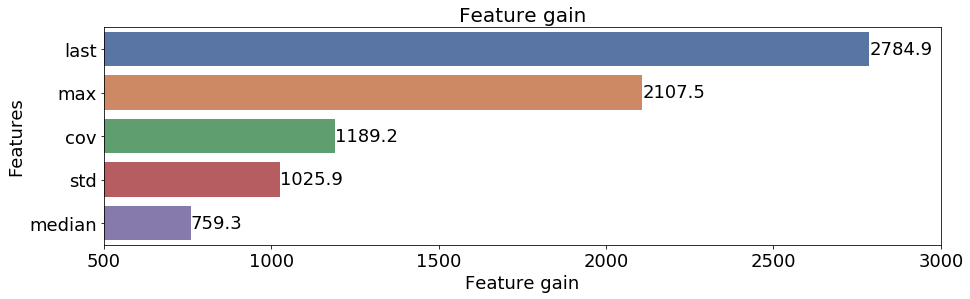

In [47]:
f, ax = plt.subplots(figsize=(15, 4))


importance_df_gain= importance_df[['feature','gain']].sort_values(by='gain', ascending=False)
sns.barplot(x=importance_df_gain['gain'], y=importance_df_gain['feature'], palette = sns.color_palette('deep'))
plt.xlim(500,3000)
plt.xticks(rotation='0',fontsize=LABEL_SIZE)
plt.yticks(rotation='0',fontsize=LABEL_SIZE)
plt.xlabel('Feature gain', fontsize=LABEL_SIZE)
plt.ylabel('Features', fontsize=LABEL_SIZE)
plt.title('Feature gain', fontsize=TITLE_SIZE)

counts = importance_df_gain['gain'].to_list()
for i in range(len(counts)):
    plt.text(counts[i]+1,i,s=str(counts[i]),horizontalalignment= 'left', verticalalignment='center', fontsize=LABEL_SIZE)

plt.savefig('聚合特征gain值.png', dpi=720, bbox_inches='tight')

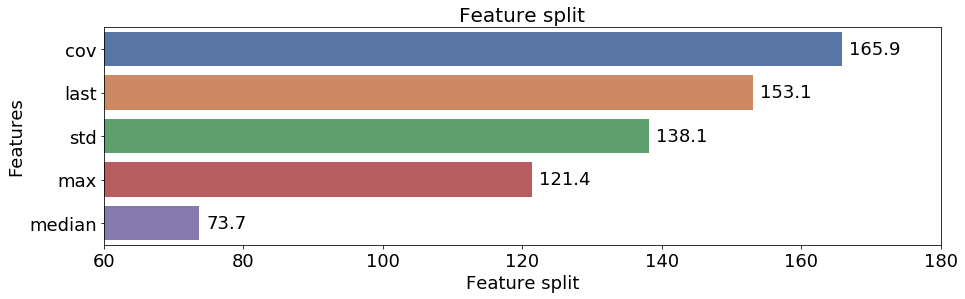

In [48]:
f, ax = plt.subplots(figsize=(15, 4))


importance_df_split= importance_df[['feature','split']].sort_values(by='split', ascending=False)
sns.barplot(x=importance_df_split['split'], y=importance_df_split['feature'], palette = sns.color_palette('deep'))
plt.xlim(60,180)
plt.xticks(rotation='0',fontsize=LABEL_SIZE)
plt.yticks(rotation='0',fontsize=LABEL_SIZE)
plt.xlabel('Feature split', fontsize=LABEL_SIZE)
plt.ylabel('Features', fontsize=LABEL_SIZE)
plt.title('Feature split', fontsize=TITLE_SIZE)


counts = importance_df_split['split'].to_list()
for i in range(len(counts)):
    plt.text(counts[i]+1,i,s=str(counts[i]),horizontalalignment= 'left', verticalalignment='center', fontsize=LABEL_SIZE)
    
plt.savefig('聚合特征split值.png', dpi=720, bbox_inches='tight')

In [49]:
importance2.loc[importance2['feature'].str.contains('.*_cov',regex=True)].sort_values(by='split',ascending=False)

,feature,split
56,x_num_22_cov,587
73,x_num_50_cov,570
52,x_num_15_cov,447
60,x_num_26_cov,395
65,x_num_33_cov,351
46,x_num_5_cov,322
67,x_num_41_cov,299
45,x_num_70_cov,275
78,x_num_69_cov,261
64,x_num_32_cov,230


In [40]:
# 相关性排名
# palette = sns.color_palette('deep')
# (train.corr()['target'].sort_values(ascending=False).head(20)).drop('target',axis=0).plot(kind='bar',figsize=(15, 8))
# plt.xlabel('Features', fontsize=12)
# plt.ylabel(' Correlations', fontsize=12) 
# plt.title(' Correlations of feartures', fontsize=14)

In [5]:
# light gain排名

In [6]:
# msno.bar(train_m.sample(train_m.shape[0]), figsize=(25, 10), labels=True)

In [7]:
# msno.bar(train_b.sample(train_b.shape[0]), figsize=(10, 5), )

In [8]:
# sns.heatmap(train_m.isnull(), yticklabels=False, cbar=False, cmap='viridis')
# # 热力图，当data中有空值时标为黄色

In [9]:
# sns.heatmap(train_b.isnull(), yticklabels=False, cbar=False, cmap='viridis')
# # 热力图，当data中有空值时标为黄色

In [10]:
# plt.figure(figsize=(10,4))
# # 创建图表、数据

# f = train_b.boxplot(sym = 'o',  # 异常点形状，参考marker
#                vert = True,  # 是否垂直
#                whis = 1.5,  # IQR，默认1.5，也可以设置区间比如[5,95]，代表强制上下边缘为数据95%和5%位置
#                patch_artist = True,  # 上下四分位框内是否填充，True为填充
#                meanline = False,showmeans=True,  # 是否有均值线及其形状
#                showbox = True,  # 是否显示箱线
#                showcaps = True,  # 是否显示边缘线
#                showfliers = True,  # 是否显示异常值
#                notch = False,  # 中间箱体是否缺口
#                return_type='dict'  # 返回类型为字典
#               ) 
# plt.title('boxplot')
# print(f)

# for box in f['boxes']:
#     box.set( color='b', linewidth=1)        # 箱体边框颜色
#     box.set( facecolor = 'b' ,alpha=0.5)    # 箱体内部填充颜色
# for whisker in f['whiskers']:
#     whisker.set(color='k', linewidth=0.5,linestyle='-')
# for cap in f['caps']:
#     cap.set(color='gray', linewidth=2)
# for median in f['medians']:
#     median.set(color='DarkBlue', linewidth=2)
# for flier in f['fliers']:
#     flier.set(marker='o', color='y', alpha=0.5)